# Data from Supernova Simulations - Garching Group

Here we take neutrino emisson (Luminosity and spectrum) from supernova simulations.

The data came from the Garching group: https://wwwmpa.mpa-garching.mpg.de/ccsnarchive/data/Bollig2016/.

The files contain time, luminosity, $E$ and $E^2$ of each flavor ($\nu_e, \bar{\nu}_e, \nu_x=\{\nu_\mu,\nu_\tau,\bar{\nu}_\mu, \bar{\nu}_\tau \}$) for different mass progenitors and equation of state used. More information in:

[Supernova Neutrinos: Production, Oscillations and Detection - A. Mirizzi, et al.](https://arxiv.org/abs/1508.00785)

[Supernova neutrino physics with xenon dark matter detectors: A timely perspective - Rafael F. Lang, et al.](https://arxiv.org/pdf/1606.09243)

To calculate $\alpha$ we can use the relation:

$$\frac{\left \langle E^2 \right \rangle}{ \left \langle E \right \rangle^2}=\frac{2+\alpha}{1+\alpha} \;\;\; \rightarrow \;\;\; \alpha = \frac{2 \left \langle E \right \rangle^2 - \left \langle E^2 \right \rangle}{\left \langle E^2 \right \rangle - \left \langle E \right \rangle^2}$$

In [1]:
#Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.special import gamma
import math 
import scipy.integrate as integrate
import time
from scipy.stats import chi2
import scipy.stats as st
import os.path
import pandas as pd 
from scipy.interpolate import interp1d
from IPython.display import HTML
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import simps
from IPython.display import display, Latex


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
root_folder="Data/Supernova_Simulation_Data_Garching/"

In [4]:
#Function for Neutrino Spectrum (phi)
erg_to_MeV=6.2415*10**5

def phi(E,E_0,L,alpha,D):  
    #E[MeV], E_0[MeV], L[10⁵²ergs], alpha, D[kpc]
    D = D *3.086*10**21 # kpc to cm
    L=L*(10**52)*erg_to_MeV
    N=((alpha+1)**(alpha+1))/(E_0*gamma(alpha+1))
    R=(L/E_0)*N*((E/E_0)**alpha)*math.exp((-1)*(alpha+1)*E/E_0)/(4*math.pi*D**2)
    return R #MeV⁻¹.cm⁻².s⁻¹

In [5]:
def integral(y, x):
    total_area = 0
    for i in range(1,len(x)):
        width = np.abs(x[i] - x[i-1])
        height = y[i-1]
        triangle_height = y[i]-y[i-1]
        area = width*height + width*triangle_height/2
        total_area += area
    return total_area

In [6]:
nu_types=['nubar_e','nu_e','nu_x']
nu_types_2=['nu_ebar','nu_e','nu_x','nu_xbar']
nu_types_3=['nu_ebar','nu_e','nu_mu','nu_mubar','nu_tau','nu_taubar']
# folder=root_folder+'neutrinos-LS220-s27.0c/'
models=['LS220-s11.2c','LS220-s27.0c','LS220-s27.0co','Shen-s11.2c','Shen-s27.0c','SFHo-s20.0',
        'SFHo-z9.6','LS220-s18.6','SFHo-s18.6-MUONS']
# Not using the model 'SFHo-s18.6'
files=['LS220-s11.2c.data','s27.0c-LS220.data','LS220-s27.0co.data','Shen-s11.2c.data','Shen-s27.0c.data',
      'SFHo-s20.0.txt','SFHo-z9.6.txt','LS220-s18.6.txt','SFHo-s18.6-MUONS.txt']
mass=[11,27,27,11.2,27,20,18.6,9.6,18.6]

total_luminosities_nu_peak = []
total_luminosties = []
fig, ax = plt.subplots()
for k in range(len(models)):
    if 'SFHo' in models[k] and 'MUONS' not in models[k]:
        t_data,E_data,E2_data,Lum_data,alpha_data=[],[],[],[],[]
        folder=root_folder+f'neutrinos-{models[k]}/'
        for i in range(len(nu_types_2)):
            #print(folder+'neutrino_signal_'+nu_types[i]+'-s27.0c-LS220.data')
            df = pd.read_csv(folder+'neutrino_signal_'+nu_types_2[i]+f'-{files[k]}',
                             delim_whitespace=True,skiprows=[0,1,2,4])
            # print(df.head(5))
            if 'z9.6' in models[k]:
                t_data.append(np.asarray(df['postbounce_time']))
            else:
                t_data.append(np.asarray(df['time']))
            E_data.append(np.asarray(df['<e>']))
            E2_data.append(np.asarray(df['<e^2>']))
            Lum_data.append(np.asarray(df['luminosity']))
            alpha_data.append([])

            for j in range(len(t_data[i])):
                alpha_aux=(2*(E_data[i][j]**2) - E2_data[i][j])/(E2_data[i][j]-(E_data[i][j]**2))
                alpha_data[i].append(alpha_aux)
        # if k == 1:
            # print(np.isnan in Lum_data[1])

        netronization_period_time_nubare = t_data[0][:np.where(t_data[0] >= 5e-2)[0][0]]
        neutronization_period_lum_nubare = Lum_data[0][:np.where(t_data[0] >= 5e-2)[0][0]]
        netronization_period_time_nue = t_data[1][:np.where(t_data[1] >= 5e-2)[0][0]]
        neutronization_period_lum_nue = Lum_data[1][:np.where(t_data[1] >= 5e-2)[0][0]]
        netronization_period_time_nux = t_data[2][:np.where(t_data[2] >= 5e-2)[0][0]]
        neutronization_period_lum_nux = Lum_data[2][:np.where(t_data[2] >= 5e-2)[0][0]]
        netronization_period_time_nubarx = t_data[3][:np.where(t_data[3] >= 5e-2)[0][0]]
        neutronization_period_lum_nubarx = Lum_data[3][:np.where(t_data[3] >= 5e-2)[0][0]]

        lum_neutro_peak_nubare = simps(neutronization_period_lum_nubare, netronization_period_time_nubare)
        lum_neutro_peak_nue = simps(neutronization_period_lum_nue, netronization_period_time_nue)
        lum_neutro_peak_nux = simps(neutronization_period_lum_nux, netronization_period_time_nux)
        lum_neutro_peak_nubarx = simps(neutronization_period_lum_nubarx, netronization_period_time_nubarx)

        if k == 1:
            lum_tot_nubare = integral(Lum_data[0], t_data[0])
            lum_tot_nue = integral(Lum_data[1], t_data[1])
            lum_tot_nux = integral(Lum_data[2], t_data[2])
            lum_tot_nubarx = integral(Lum_data[3], t_data[3])
            total_luminosties.append((lum_tot_nubare + lum_tot_nue + 2*lum_tot_nux + 2*lum_tot_nubarx)*1e51)
        else:
            lum_tot_nubare = simps(Lum_data[0], t_data[0])
            lum_tot_nue = simps(Lum_data[1], t_data[1])
            lum_tot_nux = simps(Lum_data[2], t_data[2])
            lum_tot_nubarx = simps(Lum_data[3], t_data[3])
            total_luminosties.append((lum_tot_nubare + lum_tot_nue + 2*lum_tot_nux + 2*lum_tot_nubarx)*1e51)

        print(f'Model {models[k]}'
             '\n'
              'Luminosity during neutrinization peak:')
        # display(Latex(r'$\overline{\nu}_e$:'+f' {lum_neutro_peak_nubare*1e51:.3e} ergs'))
        # display(Latex(r'$\nu_e$:'+f' {lum_neutro_peak_nue*1e51:.3e} ergs'))
        # display(Latex(r'$\nu_x$:'+f' {lum_neutro_peak_nux*1e51:.3e} ergs'))
        # display(Latex(r'$\overline{\nu}_x$:'+f' {lum_neutro_peak_nubarx*1e51:.3e} ergs'))
        display(Latex(r'Total luminosity during neutronization peak ($\overline{\nu}_e + \nu_e + 2\nu_x + 2\overline{\nu}_x$):'+f' {(lum_neutro_peak_nubare+lum_neutro_peak_nue+ 2*lum_neutro_peak_nux + 2*lum_neutro_peak_nubarx)*1e51:.3e} ergs'))
        display(Latex(r'Total luminosity ($\overline{\nu}_e + \nu_e + 2\nu_x + \overline{\nu}_x$):'+f' {(lum_tot_nubare + lum_tot_nue + 2*lum_tot_nux + 2*lum_tot_nubarx)*1e51:.3e} ergs'))
        print('-----------')
        total_luminosities_nu_peak.append((lum_neutro_peak_nubare+lum_neutro_peak_nue+ 2*lum_neutro_peak_nux + 2*lum_neutro_peak_nubarx)*1e51)
        # fig, ax = plt.subplots()
        # plt.plot(t_data[0], Lum_data[0])
        plt.plot(t_data[1], Lum_data[1], label = models[k])
        # plt.plot(t_data[2], Lum_data[2])
    elif 'SFHo' in models[k] and 'MUONS' in models[k]:
        t_data,E_data,E2_data,Lum_data,alpha_data=[],[],[],[],[]
        folder=root_folder+f'neutrinos-{models[k]}/'
        for i in range(len(nu_types_3)):
            #print(folder+'neutrino_signal_'+nu_types[i]+'-s27.0c-LS220.data')
            df = pd.read_csv(folder+'neutrino_signal_'+nu_types_3[i]+f'-{files[k]}',
                             delim_whitespace=True,skiprows=[0,1,2,4])
            # print(df.head(5))
            if 'z9.6' in models[k]:
                t_data.append(np.asarray(df['postbounce_time']))
            else:
                t_data.append(np.asarray(df['time']))
            E_data.append(np.asarray(df['<e>']))
            E2_data.append(np.asarray(df['<e^2>']))
            Lum_data.append(np.asarray(df['luminosity']))
            alpha_data.append([])

            for j in range(len(t_data[i])):
                alpha_aux=(2*(E_data[i][j]**2) - E2_data[i][j])/(E2_data[i][j]-(E_data[i][j]**2))
                alpha_data[i].append(alpha_aux)
        # if k == 1:
            # print(np.isnan in Lum_data[1])

        netronization_period_time_nubare = t_data[0][:np.where(t_data[0] >= 5e-2)[0][0]]
        neutronization_period_lum_nubare = Lum_data[0][:np.where(t_data[0] >= 5e-2)[0][0]]
        netronization_period_time_nue = t_data[1][:np.where(t_data[1] >= 5e-2)[0][0]]
        neutronization_period_lum_nue = Lum_data[1][:np.where(t_data[1] >= 5e-2)[0][0]]
        netronization_period_time_numu = t_data[2][:np.where(t_data[2] >= 5e-2)[0][0]]
        neutronization_period_lum_numu = Lum_data[2][:np.where(t_data[2] >= 5e-2)[0][0]]
        netronization_period_time_nubarmu = t_data[3][:np.where(t_data[3] >= 5e-2)[0][0]]
        neutronization_period_lum_nubarmu = Lum_data[3][:np.where(t_data[3] >= 5e-2)[0][0]]
        netronization_period_time_nutau = t_data[4][:np.where(t_data[4] >= 5e-2)[0][0]]
        neutronization_period_lum_nutau = Lum_data[4][:np.where(t_data[4] >= 5e-2)[0][0]]
        netronization_period_time_nubartau = t_data[5][:np.where(t_data[5] >= 5e-2)[0][0]]
        neutronization_period_lum_nubartau = Lum_data[5][:np.where(t_data[5] >= 5e-2)[0][0]]

        lum_neutro_peak_nubare = simps(neutronization_period_lum_nubare, netronization_period_time_nubare)
        lum_neutro_peak_nue = simps(neutronization_period_lum_nue, netronization_period_time_nue)
        lum_neutro_peak_numu = simps(neutronization_period_lum_numu, netronization_period_time_numu)
        lum_neutro_peak_nubarmu = simps(neutronization_period_lum_nubarmu, netronization_period_time_nubarmu)
        lum_neutro_peak_nutau = simps(neutronization_period_lum_nutau, netronization_period_time_nutau)
        lum_neutro_peak_nubartau = simps(neutronization_period_lum_nubartau, netronization_period_time_nubartau)

        if k == 1:
            lum_tot_nubare = integral(Lum_data[0], t_data[0])
            lum_tot_nue = integral(Lum_data[1], t_data[1])
            lum_tot_numu = integral(Lum_data[2], t_data[2])
            lum_tot_nubarmu = integral(Lum_data[3], t_data[3])
            lum_tot_nutau = integral(Lum_data[4], t_data[4])
            lum_tot_nubartau = integral(Lum_data[5], t_data[5])
            total_luminosties.append((lum_tot_nubare + lum_tot_nue + lum_tot_numu + lum_tot_nubarmu + lum_tot_nutau + lum_tot_nubartau)*1e51)
        else:
            lum_tot_nubare = simps(Lum_data[0], t_data[0])
            lum_tot_nue = simps(Lum_data[1], t_data[1])
            lum_tot_numu = simps(Lum_data[2], t_data[2])
            lum_tot_nubarmu = simps(Lum_data[3], t_data[3])
            lum_tot_nutau = integral(Lum_data[4], t_data[4])
            lum_tot_nubartau = integral(Lum_data[5], t_data[5])
            total_luminosties.append((lum_tot_nubare + lum_tot_nue + lum_tot_numu + lum_tot_nubarmu + lum_tot_nutau + lum_tot_nubartau)*1e51)

        print(f'Model {models[k]}'
             '\n'
              'Luminosity during neutrinization peak:')
        # display(Latex(r'$\overline{\nu}_e$:'+f' {lum_neutro_peak_nubare*1e51:.3e} ergs'))
        # display(Latex(r'$\nu_e$:'+f' {lum_neutro_peak_nue*1e51:.3e} ergs'))
        # display(Latex(r'$\nu_x$:'+f' {lum_neutro_peak_nux*1e51:.3e} ergs'))
        # display(Latex(r'$\overline{\nu}_x$:'+f' {lum_neutro_peak_nubarx*1e51:.3e} ergs'))
        display(Latex(r'Total luminosity during neutronization peak ($\overline{\nu}_e + \nu_e + \nu_\mu + \overline{\nu}_\mu$):'+f' {(lum_neutro_peak_nubare+lum_neutro_peak_nue + lum_neutro_peak_numu + lum_neutro_peak_nubarmu + lum_neutro_peak_nutau + lum_neutro_peak_nubartau)*1e51:.3e} ergs'))
        display(Latex(r'Total luminosity ($\overline{\nu}_e + \nu_e + \nu_\mu + \overline{\nu}_\mu$):'+f' {(lum_tot_nubare + lum_tot_nue + lum_tot_numu + lum_tot_nubarmu + lum_tot_nutau + lum_tot_nubartau)*1e51:.3e} ergs'))
        print('-----------')
        total_luminosities_nu_peak.append((lum_neutro_peak_nubare+lum_neutro_peak_nue+ lum_neutro_peak_numu + lum_neutro_peak_nubarmu + lum_neutro_peak_nutau + lum_neutro_peak_nubartau)*1e51)
        # fig, ax = plt.subplots()
        # plt.plot(t_data[0], Lum_data[0])
        plt.plot(t_data[1], Lum_data[1], label = models[k])
        # plt.plot(t_data[2], Lum_data[2])
    else:
        t_data,E_data,E2_data,Lum_data,alpha_data=[],[],[],[],[]
        folder=root_folder+f'neutrinos-{models[k]}/'
        for i in range(len(nu_types)):
            if 's18.6' in models[k]:
                df = pd.read_csv(folder+'neutrino_signal_'+nu_types_2[i]+f'-{files[k]}',
                             delim_whitespace=True,skiprows=[0,1,2,4])
            #print(folder+'neutrino_signal_'+nu_types[i]+'-s27.0c-LS220.data')
            else:
                df = pd.read_csv(folder+'neutrino_signal_'+nu_types[i]+f'-{files[k]}',
                                 delim_whitespace=True,skiprows=[0,1,2,4])
            # print(df.head(5))
            t_data.append(np.asarray(df['time']))
            E_data.append(np.asarray(df['<e>']))
            E2_data.append(np.asarray(df['<e^2>']))
            Lum_data.append(np.asarray(df['luminosity']))
            alpha_data.append([])

            for j in range(len(t_data[i])):
                alpha_aux=(2*(E_data[i][j]**2) - E2_data[i][j])/(E2_data[i][j]-(E_data[i][j]**2))
                alpha_data[i].append(alpha_aux)
        # if k == 1:
            # print(np.isnan in Lum_data[1])

        netronization_period_time_nubare = t_data[0][:np.where(t_data[0] >= 5e-2)[0][0]]
        neutronization_period_lum_nubare = Lum_data[0][:np.where(t_data[0] >= 5e-2)[0][0]]
        netronization_period_time_nue = t_data[1][:np.where(t_data[1] >= 5e-2)[0][0]]
        neutronization_period_lum_nue = Lum_data[1][:np.where(t_data[1] >= 5e-2)[0][0]]
        netronization_period_time_nux = t_data[2][:np.where(t_data[2] >= 5e-2)[0][0]]
        neutronization_period_lum_nux = Lum_data[2][:np.where(t_data[2] >= 5e-2)[0][0]]

        lum_neutro_peak_nubare = simps(neutronization_period_lum_nubare, netronization_period_time_nubare)
        lum_neutro_peak_nue = simps(neutronization_period_lum_nue, netronization_period_time_nue)
        lum_neutro_peak_nux = simps(neutronization_period_lum_nux, netronization_period_time_nux)

        if k == 1:
            lum_tot_nubare = integral(Lum_data[0], t_data[0])
            lum_tot_nue = integral(Lum_data[1], t_data[1])
            lum_tot_nux = integral(Lum_data[2], t_data[2])
            total_luminosties.append((lum_tot_nubare + lum_tot_nue + 4*lum_tot_nux)*1e51)
        else:
            lum_tot_nubare = simps(Lum_data[0], t_data[0])
            lum_tot_nue = simps(Lum_data[1], t_data[1])
            lum_tot_nux = simps(Lum_data[2], t_data[2])
            total_luminosties.append((lum_tot_nubare + lum_tot_nue + 4*lum_tot_nux)*1e51)

        print(f'Model {models[k]}'
             '\n'
              'Luminosity during neutrinization peak:')
        # display(Latex(r'$\overline{\nu}_e$:'+f' {lum_neutro_peak_nubare*1e51:.3e} ergs'))
        # display(Latex(r'$\nu_e$:'+f' {lum_neutro_peak_nue*1e51:.3e} ergs'))
        # display(Latex(r'$\nu_x$:'+f' {lum_neutro_peak_nux*1e51:.3e} ergs'))
        display(Latex(r'Total luminosity during neutronization peak ($\overline{\nu}_e + \nu_e + 4\nu_x$):'+f' {(lum_neutro_peak_nubare+lum_neutro_peak_nue+4*lum_neutro_peak_nux)*1e51:.3e} ergs'))
        display(Latex(r'Total luminosity ($\overline{\nu}_e + \nu_e + 4\nu_x$):'+f' {(lum_tot_nubare + lum_tot_nue + 4*lum_tot_nux)*1e51:.3e} ergs'))
        print('-----------')
        total_luminosities_nu_peak.append((lum_neutro_peak_nubare+lum_neutro_peak_nue+4*lum_neutro_peak_nux)*1e51)
        # fig, ax = plt.subplots()
        # plt.plot(t_data[0], Lum_data[0])
        plt.plot(t_data[1], Lum_data[1], label = models[k])
        # plt.plot(t_data[2], Lum_data[2])
plt.xscale('log')
plt.xlim(1e-4, 1e-1)
plt.ylim(0, 400)
plt.legend(loc='upper left')
plt.xlabel(r'Time post bounce [ms]', fontsize = 14)
plt.ylabel(r'Luminosity [$10^{51}$ ergs/s]', fontsize = 14)
# plt.savefig('Plots/Garching_group_simulations_luminosities.png', dpi = 300,
#             bbox_inches = 'tight')
plt.show()

Model LS220-s11.2c
Luminosity during neutrinization peak:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-----------
Model LS220-s27.0c
Luminosity during neutrinization peak:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-----------
Model LS220-s27.0co
Luminosity during neutrinization peak:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-----------
Model Shen-s11.2c
Luminosity during neutrinization peak:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-----------


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Supernova_Simulation_Data_Garching/neutrinos-Shen-s27.0c/neutrino_signal_nubar_e-Shen-s27.0c.data'

In [112]:
100*np.array(total_luminosities_nu_peak)/np.array(total_luminosties)

array([5.78833622, 4.51161508, 4.22372726, 6.3173269 , 4.75205511,
       3.72953508, 5.49963599, 5.33247863, 4.87673602])

In [113]:
[np.nanstd(total_luminosties), np.std(total_luminosities_nu_peak)]

[7.844055271416694e+52, 1.7711785171122433e+51]

In [114]:
[np.nanmean(total_luminosties), np.mean(total_luminosities_nu_peak)]

[2.66175435705668e+53, 1.2738371607685845e+52]

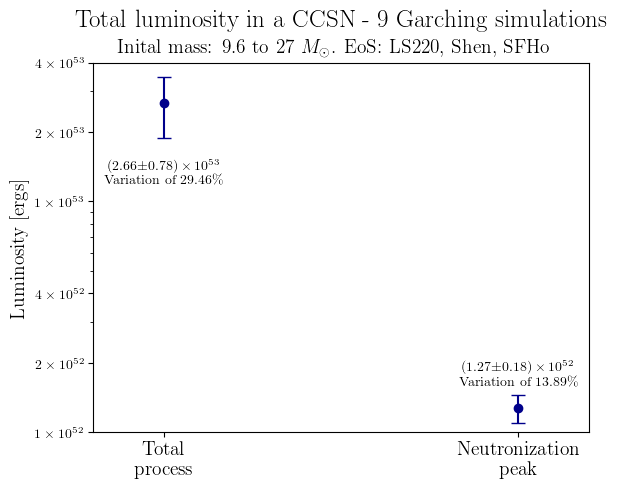

In [115]:
fig, ax = plt.subplots()
plt.scatter([0,1], [np.nanmean(total_luminosties), np.mean(total_luminosities_nu_peak)],
           color = 'darkblue')
plt.errorbar([0,1], [np.nanmean(total_luminosties), np.mean(total_luminosities_nu_peak)],
             yerr = [np.nanstd(total_luminosties), np.std(total_luminosities_nu_peak)],
            fmt = 'none', color = 'darkblue', capsize = 5)
plt.yscale('log')
plt.ylim(1e52, 4e53)
plt.xlim(-0.2, 1.2)
plt.yticks([1e52, 2e52, 4e52, 1e53, 2e53, 4e53],
          labels = [r'$1 \times 10^{52}$', r'$2 \times 10^{52}$',
                    r'$4 \times 10^{52}$', r'$1 \times 10^{53}$', r'$2 \times 10^{53}$',
                    r'$4 \times 10^{53}$'])
plt.xticks([0,1], labels = ['Total \n process','Neutronization \n peak'],
          fontsize = 14)
plt.ylabel('Luminosity [ergs]', fontsize = 14)
plt.text(0, 1.2e53, f'({str(np.nanmean(total_luminosties))[:4]}'+r'$\pm 0.78) \times 10^{53}$'
         '\n'
         f'Variation of {(100*0.784/2.661):.2f}\%', ha = 'center')
plt.text(1, 1.6e52, f'({str(np.nanmean(total_luminosities_nu_peak))[:4]}'+r'$\pm 0.18) \times 10^{52}$'
         '\n'
         f'Variation of {(100*0.177/1.274):.2f}\%', ha = 'center')
plt.title('Total luminosity in a CCSN - 9 Garching simulations', fontsize = 18,
         pad = 26)
fig.text(0.5, 0.9, r'Inital mass: 9.6 to 27 $M_\odot$. EoS: LS220, Shen, SFHo',
         fontsize = 14, ha = 'center')
# plt.grid(True, which = 'both', ls = '--',
#         alpha = 0.5)
plt.savefig('Plots/Total_luminosity_CCSN_garching_group.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [118]:
r, p = st.pearsonr(total_luminosties, total_luminosities_nu_peak)

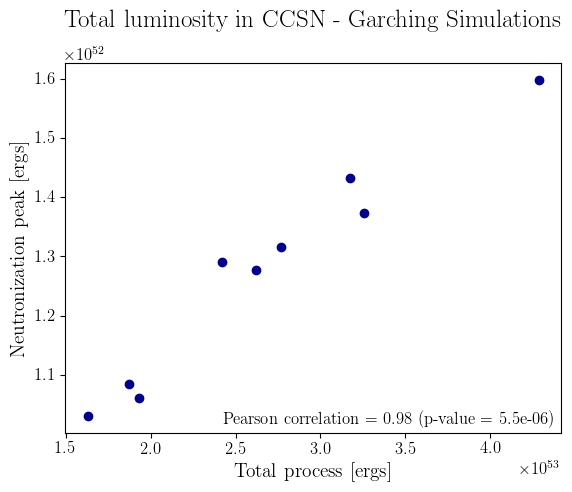

In [119]:
fig, ax = plt.subplots()
plt.scatter(total_luminosties, total_luminosities_nu_peak,
           color = 'darkblue')
# plt.ylim(1e52, 4e53)
# plt.xlim(-0.2, 1.2)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Total process [ergs]', fontsize = 14)
plt.ylabel('Neutronization peak [ergs]', fontsize = 14)
plt.title('Total luminosity in CCSN - Garching Simulations', fontsize = 18,
         pad = 26)
ax.yaxis.offsetText.set_fontsize(12)
ax.xaxis.offsetText.set_fontsize(12)
fig.text(0.63, 0.13, f'Pearson correlation = {r:.2f} (p-value = {p:.1e})',
         fontsize = 12, ha = 'center')
# # plt.grid(True, which = 'both', ls = '--',
# #         alpha = 0.5)
plt.savefig('Plots/Total_luminosity_CCSN_garching_group_relation_between_phases.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

Supernova Model: Shen-s11.2c


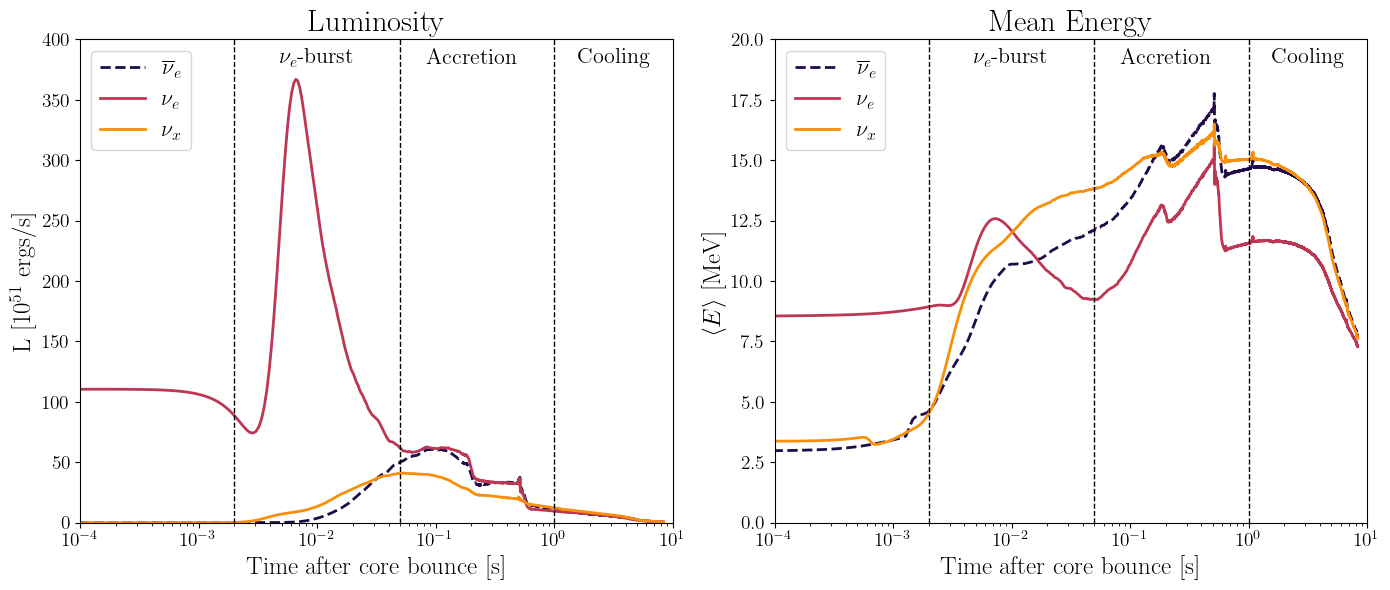

In [19]:
#Ploting

cmap = 'inferno'

plt.figure(figsize=(14,6), facecolor='w', edgecolor='k')
print("Supernova Model:", models[3])
plt.subplot(1,2,1)
plt.title(r"Luminosity", fontsize = 22)
plt.plot(t_data[0],Lum_data[0],label=r'$\overline{\nu}_e$', lw = 2, color = sns.color_palette(cmap, 7)[0],
        ls = '--')
plt.plot(t_data[1],Lum_data[1],label=r'$\nu_e$', lw = 2, color = sns.color_palette(cmap, 7)[3])
plt.plot(t_data[2],Lum_data[2],label=r'$\nu_x$', lw = 2, color = sns.color_palette(cmap, 7)[5])
plt.xlabel(r'Time after core bounce [s]', fontsize = 18)
plt.xscale('log')
plt.ylabel(r'L [$10^{51}$ ergs/s]', fontsize = 18)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(loc='upper left', fontsize = 16)
plt.axvline(2e-3, ls = '--', lw = 1, color = 'black')
plt.text(1e-2, 380, r'$\nu_e$-burst', fontsize = 16, ha = 'center')
plt.axvline(5e-2, ls = '--', lw = 1, color = 'black')
plt.text(2e-1, 380, r'Accretion', fontsize = 16, ha = 'center')
plt.axvline(1, ls = '--', lw = 1, color = 'black')
plt.text(3.2e0, 380, r'Cooling', fontsize = 16, ha = 'center')
plt.xlim(1e-4, 1e1)
plt.ylim(0, 400)

plt.subplot(1,2,2)
plt.title(r"Mean Energy", fontsize = 22)
plt.plot(t_data[0],E_data[0],label=r'$\overline{\nu}_e$', lw = 2, color = sns.color_palette(cmap, 7)[0],
        ls = '--')
plt.plot(t_data[1],E_data[1],label=r'$\nu_e$', lw = 2, color = sns.color_palette(cmap, 7)[3])
plt.plot(t_data[2],E_data[2],label=r'$\nu_x$', lw = 2, color = sns.color_palette(cmap, 7)[5])
plt.xlabel(r'Time after core bounce [s]', fontsize = 18)
plt.xscale('log')
plt.ylabel(r'$\left \langle E \right \rangle$ [MeV]', fontsize = 18)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(loc='upper left', fontsize = 16)
plt.axvline(2e-3, ls = '--', lw = 1, color = 'black')
plt.text(1e-2, 19, r'$\nu_e$-burst', fontsize = 16, ha = 'center')
plt.axvline(5e-2, ls = '--', lw = 1, color = 'black')
plt.text(2e-1, 19, r'Accretion', fontsize = 16, ha = 'center')
plt.axvline(1, ls = '--', lw = 1, color = 'black')
plt.text(3.2e0, 19, r'Cooling', fontsize = 16, ha = 'center')
plt.xlim(1e-4, 1e1)
plt.ylim(0, 20)

# plt.subplot(1,3,3)
# plt.title(r"$\alpha$")
# plt.plot(t_data[0],alpha_data[0],label=r'$\bar{\nu}_e$')
# plt.plot(t_data[1],alpha_data[1],label=r'$\nu_e$')
# plt.plot(t_data[2],alpha_data[2],label=r'$\nu_x$')
# plt.xlabel(r'time[s]')
# plt.xscale('log')
# plt.ylabel(r'$\alpha$')
# plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('Plots/nu_emission_curves_garching_group.svg', dpi = 300, bbox_inches = 'tight')
# plt.savefig('Plots/nu_emission_curves_garching_group.png', dpi = 300, bbox_inches = 'tight')
plt.show()

100%|██████████| 10/10 [00:00<00:00, 589.19it/s]


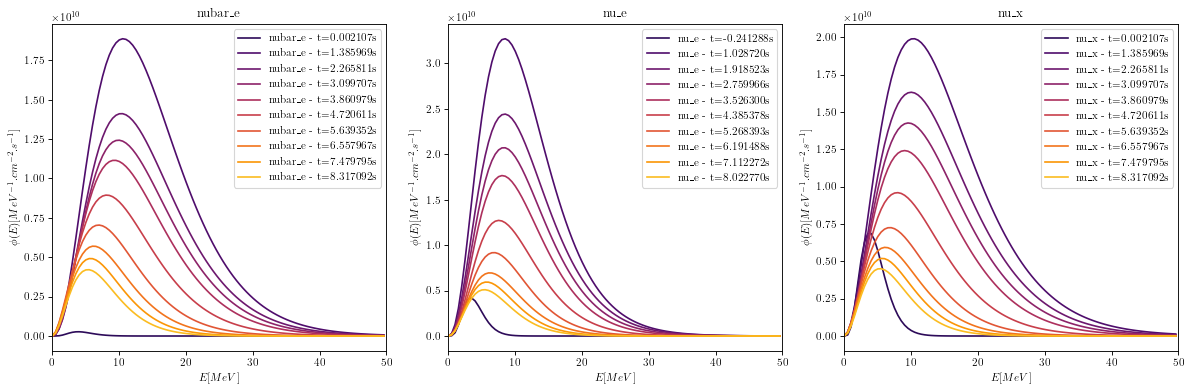

In [20]:
#Spectrum plot
E_vec=np.arange(0.1, 50, 0.5) #eV
phi_vec= np.vectorize(phi)

plt.figure(figsize=(15,5), dpi= 80, facecolor='w', edgecolor='k')

for j in range(len(nu_types)):
    plt.subplot(1,3,j+1)
    for i in tqdm(range(1,11)):
        if i < 2:
            idx = i*100
        else:
            idx = i*900
        plt.plot(E_vec,phi_vec(E_vec,E_data[j][idx],Lum_data[j][idx],alpha_data[j][idx],10),
                 label=r'%s - t=%fs'%(nu_types[j],t_data[j][idx]),
                color = sns.color_palette('inferno', 12)[i])
    plt.xlabel(r'$E [MeV]$')
    plt.ylabel(r'$\phi(E) [MeV^{-1}.cm^{-2}.s^{-1}]$')
    # plt.yscale('log')
    plt.title(nu_types[j])
    plt.legend(loc='upper right')
    plt.xlim(0,50)
    
plt.tight_layout()
plt.show()

In [21]:
def nu_flux_0_time_int(Enu,D,nu_type):
    inte=0
    for i in range(len(t_data[nu_type])-1):
        delta_t=t_data[nu_type][i+1]-t_data[nu_type][i]
        phi_mean=(phi_vec(Enu,E_data[nu_type][i],Lum_data[nu_type][i],alpha_data[nu_type][i],D)+phi_vec(Enu,E_data[nu_type][i+1],Lum_data[nu_type][i+1],alpha_data[nu_type][i+1],D))/2
        inte= inte+(phi_mean*delta_t)
    return inte
    
def phi_10kpc(E,E_0,L,alpha):
    res=phi_vec(E,E_0,L,alpha,10)
    return res

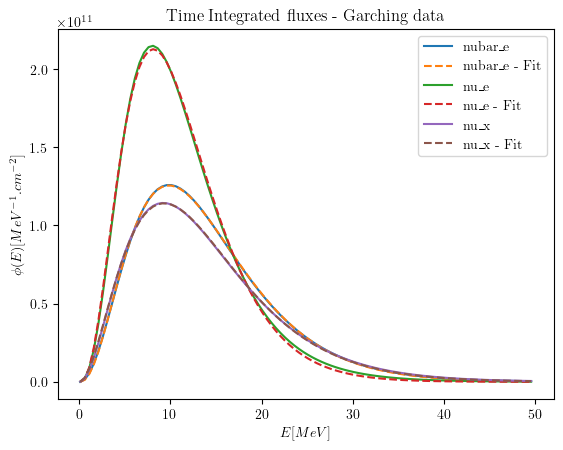

Took: 1.332884673277537 minutes


In [22]:
#Fit model to the data
from scipy.optimize import curve_fit
popt, pcov=[],[]
start_time = time.time()
for j in range(len(nu_types)):
    popt_aux, pcov_aux = curve_fit(phi_10kpc,E_vec,nu_flux_0_time_int(E_vec,10,j),p0=[10,5,2.3])
    popt.append(popt_aux)
    #plt.subplot(1,3,j+1)
    plt.plot(E_vec,nu_flux_0_time_int(E_vec,10,j),label=r'%s'%(nu_types[j]))
    plt.plot(E_vec,phi_10kpc(E_vec,popt_aux[0],popt_aux[1],popt_aux[2]),'--',label=r'%s - Fit'%(nu_types[j]))
plt.xlabel(r'$E [MeV]$')
plt.ylabel(r'$\phi(E) [MeV^{-1}.cm^{-2}]$')
#plt.yscale('log')
plt.title("Time Integrated fluxes - Garching data")
plt.legend(loc='upper right')
plt.show()
print("Took: %s minutes" % ((time.time() - start_time)/60))

In [23]:
print('nubar_e',popt[0][0],popt[0][1],popt[0][2])
print('nu_e',popt[1][0],popt[1][1],popt[1][2])
print('nu_x',popt[2][0],popt[2][1],popt[2][2])

nubar_e 13.822869350649178 54.04548008734123 2.466686649306164
nu_e 11.060715458579558 56.9764097395986 2.757723623918388
nu_x 13.759969333007556 50.652173443609584 2.075505955490069


In [24]:
(popt[0][1]+popt[1][1]+popt[2][1])*1e52

1.616740632705494e+54

In [25]:
total_flux = nu_flux_0_time_int(E_vec,10,0)+nu_flux_0_time_int(E_vec,10,1)+nu_flux_0_time_int(E_vec,10,2)

In [27]:
popt_aux, pcov_aux = curve_fit(phi_10kpc,E_vec,total_flux,p0=[10,5,2.3])

In [87]:
100*(simps(total_flux, E_vec) - simps(phi_10kpc(E_vec,*popt_aux), E_vec))/simps(phi_10kpc(E_vec,*popt_aux), E_vec)

0.8352634090855536

In [88]:
1e4*0.0083

83.0

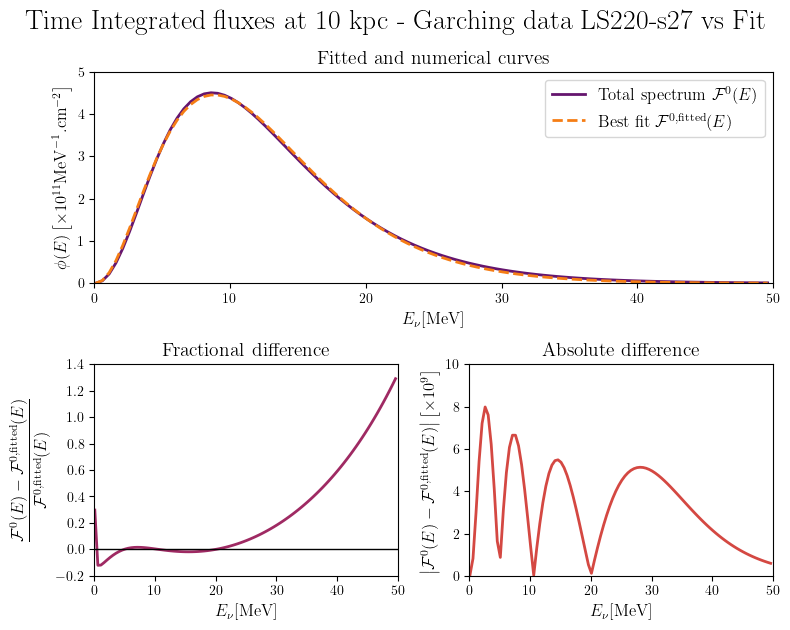

In [82]:
fig, ax = plt.subplots(figsize=(8,6))
plt.subplot(2,2,(1,2))
plt.plot(E_vec,total_flux,label=r'Total spectrum $\mathcal{F}^0(E)$', lw = 2, color = sns.color_palette('inferno')[1])
plt.plot(E_vec,phi_10kpc(E_vec,*popt_aux),'--',label=r'Best fit $\mathcal{F}^{0,\mathrm{fitted}}(E)$', color = sns.color_palette('inferno')[4], lw = 2)
plt.legend(fontsize = 12)
# plt.yscale('log')
plt.xlabel(r'$E_\nu [\mathrm{MeV}]$', fontsize = 12)
plt.ylabel(r'$\phi(E) \left[\times 10^{11} \mathrm{MeV}^{-1}.\mathrm{cm}^{-2} \right]$', fontsize = 12)
plt.title('Fitted and numerical curves', fontsize = 14)
plt.xlim(0, 50)
plt.ylim(0, 5e11)
plt.yticks([0, 1e11, 2e11, 3e11, 4e11, 5e11], labels = [0, 1, 2, 3, 4, 5])

plt.subplot(2,2,3)
plt.plot(E_vec, (total_flux - phi_10kpc(E_vec,*popt_aux))/phi_10kpc(E_vec,*popt_aux), lw = 2, color = sns.color_palette('inferno')[2])
# plt.yscale('log')
plt.xlabel(r'$E_\nu [\mathrm{MeV}]$', fontsize = 12)
plt.ylabel(r'$\displaystyle \frac{\mathcal{F}^0(E) - \mathcal{F}^{0,\mathrm{fitted}}(E)}{\mathcal{F}^{0,\mathrm{fitted}}(E)}$', fontsize = 12)
plt.xlim(0, 50)
plt.ylim(-0.2, 1.4)
plt.yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
plt.axhline(0, lw = 1, color = 'black')
plt.title('Fractional difference', fontsize = 14)

plt.subplot(2,2,4)
plt.plot(E_vec, np.abs(total_flux - phi_10kpc(E_vec,*popt_aux)), lw = 2, color = sns.color_palette('inferno')[3])
# plt.yscale('log')
plt.xlabel(r'$E_\nu [\mathrm{MeV}]$', fontsize = 12)
plt.ylabel(r'$\displaystyle \left| \mathcal{F}^0(E) - \mathcal{F}^{0,\mathrm{fitted}}(E) \right| \left[\times 10^9 \right]$', fontsize = 12)
plt.xlim(0, 50)
plt.ylim(0, 10e9)
plt.yticks([0, 2e9, 4e9, 6e9, 8e9, 10e9], labels = [0, 2, 4, 6, 8, 10])
plt.title('Absolute difference', fontsize = 14)

fig.text(0.5, 1.01, "Time Integrated fluxes at 10 kpc - Garching data LS220-s27 vs Fit", fontsize = 20, ha = 'center')
plt.tight_layout()
plt.savefig('Plots/fit_garching_data_total_spectrum.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('Plots/fit_garching_data_total_spectrum.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

# NS Merger simulations

In [11]:
#Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import gamma
import math 
import scipy.integrate as integrate
import time
from scipy.stats import chi2
import os.path
import pandas as pd
from scipy.interpolate import interp1d
from IPython.display import HTML
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
import h5py

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
root_folder="/home/pedroc/Documentos/pedro/Mestradives/NS_merger_Simulation_Data_Garching/"

In [4]:
model = 'M3A8m3a5'

In [61]:
densities = []
for i in tqdm(range(len(files))):
    df = pd.read_csv(root_folder + f'{model}_traject_files_rev4/traject_files/{files[i]}', skiprows = [0,1,2,3],
               sep = '    ')
    densities.append(df[df.columns[3]].values[0])
    
print(max(densities))

100%|██████████| 1924/1924 [04:00<00:00,  7.98it/s]

584984030000.0


In [62]:
files = os.listdir(root_folder + model + '_traject_files_rev4/traject_files')

for j in tqdm(range(20)):
    fig, ax = plt.subplots()
    plt.subplot(projection = 'polar')
    for i in range(len(files)):
        df = pd.read_csv(root_folder + f'{model}_traject_files_rev4/traject_files/{files[i]}', skiprows = [0,1,2,3],
                   sep = '    ')
        plt.scatter(df[df.columns[2]].values[j], df[df.columns[1]].values[j]/1e5, s = 10,
                   color = sns.color_palette('inferno', 50)[int(49*df[df.columns[3]].values[0]/max(densities))])

    plt.grid(False)
    plt.scatter(0, 0, s = 20, color = 'black', edgecolor = 'white')
    plt.ylim(0, 800)
    plt.yticks([])
    for ax in fig.axes:
        ax.patch.set_color('dimgrey')
    plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Black-hole-neutrinos/Gif/BH-NS_merger_t_index_{j}_{model}_Garching.png',
               bbox_inches = 'tight')
    plt.close()

100%|██████████| 10/10 [21:27<00:00, 128.76s/it]


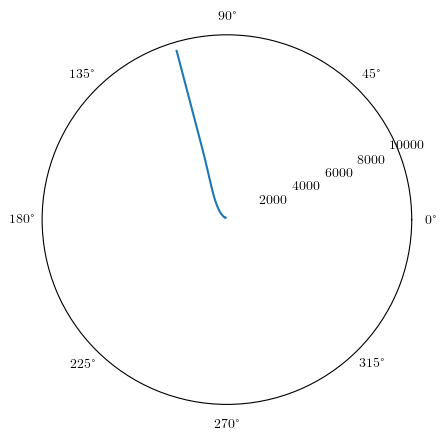

In [64]:
fig, ax = plt.subplots()
plt.subplot(projection = 'polar')
plt.plot(df.iloc[1:][df.columns[2]].values, df.iloc[1:][df.columns[1]].values/1e5)
plt.grid(False)
plt.show()

In [65]:
f = h5py.File(root_folder+model+'_25ms.h5','r+')

In [ ]:
# ************************************************************
# Nomenclature of file name
# ************************************************************
# M - initial mass of the BH  [Msol]
# A - initial spin parameter of the BH [0.1]
# m - initial mass of the torus in [0.1 Msol]
# a - viscosity alpha parameter [0.01]

# ************************************************************
# General comments 
# ************************************************************
# - for baryonic composition, 4 species were taken into
#   account, while they were assumed to be always in NSE:
#     neutrons, protons, alpha-nuclei, 54 manganese,
#   where we denote their mass fractions as
#     X_n     , X_p    , X_a         , X_h
# - the grid is defined in spherical coordinates
# - in each coordinate direction we have 6 boundary/ghost 
#   cells at both ends
# - both grids are non-uniform


# ************************************************************
# Content of the data file
# ************************************************************
#
# --- global quantities 
# Mbh0 - initial mass of the BH [Msol]
# Abh0 - initial spin parameter of the BH [1]
# Mbht - mass of BH at snapshot time [Msol]
# Abht - spin parameter of BH at snapshot time [1]
# alp  - viscosity parameter alpha [1]
# Ma   - mass accretion rate at snapshot time [Msol/s]
# m0   - initial mass of the torus in [Msol]
# mt   - torus mass at snapshot time [Msol]
# t    - present time after start of simulation [ms]
# nx   - dimension of radial grid
# ny   - dimension of theta (polar angle) grid
# xmin,xmax,ymin,ymax - min/max radius [cm], min/max theta [rad]
# nq   - number of energy groups for spectral neutrino transport
# ns   - number of neutrino species
#
# --- arrays / local quantities
# xl,xc,xr - left boundaries, centers, right boundaries of radial grid cells ( dims = [ nx ] ) [cm]
# yl,yc,yr - left boundaries, centers, right boundaries of polar-angle grid cells ( dims = [ ny ] ) [rad]
# el,ec,er - left boundaries, centers, right boundaries of neutrino energy bins ( dims = [ nq ] ) [MeV]
#
# u - hydro array ( dims = [ nu, nx, ny ] )
#
#      The corresponding index running from 1 to nu labels the
#      following quantities:
#         1 - density ( rho ) [CGS]
#         2 - total energy ( e_tot = e_int + e_kin ) [CGS]
#         3 - rho * Y_e
#         4 - rho * ( 1 - Y_e )
#         5 - rho * X_n
#         6 - rho * X_p
#         7 - rho * X_a
#         8 - rho * X_h
#      9-11 - rho * v_{rad,theta,phi} [CGS]
#
# thd - thermodynamics array ( dims = [ nthd, nx, ny ] )
#
#      The corresponding index running from 1 to nthd labels the
#      following quantities:
#         1 - pressure [CGS]
#         2 - sound-velocity [CGS]
#         3 - adiabatic index gamma 
#         4 - temperature [MeV]
#         5 - entropy [ k_B per baryon ]
#       6-9 - X_{n,p,a,h}
#     10-11 - mass number of heavy, charge number of_heavy
#     12-15 - chemical potentials of e-, n, p, nu_e [MeV]
#
#
# e - 0th- and 1st-angular moments of the neutrino intensity ( dims = [ nf, ns, nq, nx, ny ] ).
#         
#      The corresponding index running from 1 to nf labels the
#      following quantities:
#         1 - 0th angular moment (energy density) [erg/cm^3]
#         2 - 1st angular moment (energy-flux density) in radial direction [erg/cm^2/s]
#         3 - 1st angular moment (energy-flux density) in polar direction [erg/cm^2/s]
#         4 - 1st angular moment (energy-flux density) in azimuthal direction [erg/cm^2/s]
#
#      The corresponding index running from 1 to ns labels the
#      following quantities:
#         1 - electron neutrinos
#         2 - electron antineutrinos
#
#      For example, 'e' is defined such that 
#        e(1,2,5,:,:) = energy per volume of electron antineutrinos in energy group nr. 5
#        e(3,1,9,:,:) = energy per area per time of electron neutrinos in energy group nr. 9

In [66]:
Mbh0 = f['Mbh0'][()]
Abh0 = f['Abh0'][()]
Mbht = f['Mbht'][()]
Abht = f['Abht'][()]
alp  = f['alp' ][()]
Ma   = f['Ma'  ][()]
m0   = f['m0'  ][()]
mt   = f['mt'  ][()]
t    = f['t'   ][()]

print('Mbh0,Abh0,Mbht,Abht,alp,Ma,m0,mt,t = ',Mbh0,Abh0,Mbht,Abht,alp,Ma,m0,mt,t)

Mbh0,Abh0,Mbht,Abht,alp,Ma,m0,mt,t =  3.001508951187134 0.800000011920929 3.1134467478633265 0.8146840232597697 0.05000000074505806 2.5618256201883636 0.29999199509620667 0.18604095238437343 25.0


In [67]:
# dimensions
nu   = f['nu'][()]
nthd = f['nthd'][()]
nx   = f['nx'][()]
ny   = f['ny'][()]
nf   = f['nf'][()]
ns   = f['ns'][()]
nq   = f['nq'][()]

# grids
xl = f['xl'][()]
xc = f['xc'][()]
xr = f['xr'][()]
yl = f['yl'][()]
yc = f['yc'][()]
yr = f['yr'][()]
el = f['el'][()]
ec = f['ec'][()]
er = f['er'][()]

# data
u   = f['u'][()].T
thd = f['thd'][()].T
e   = f['e'][()].T

f.close()

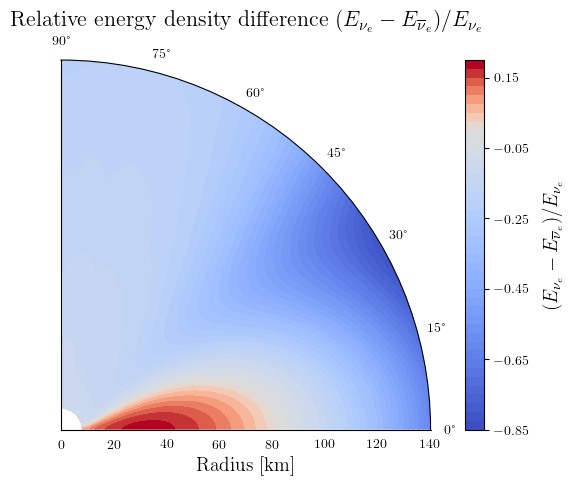

In [70]:
fig, ax = plt.subplots()
plt.subplot(projection = 'polar')
divnorm = mpl.colors.TwoSlopeNorm(vmin=-0.85, vcenter=0., vmax=0.18)
contour = plt.contourf(yc-np.pi/2, xc[:191]/1e5, (np.sum(e[0][0], axis = 0)[:191] - np.sum(e[0][1], axis = 0)[:191])/np.sum(e[0][0], axis = 0)[:191],
                       cmap = 'coolwarm', levels = 50, norm = divnorm)
cbar = plt.colorbar(contour, pad = 0.07, ticks = [-0.85, -0.65, -0.45, -0.25, -0.05, 0.15])
# cbar.ax.set_yticklabels([r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$',
#                         r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
cbar.set_label(label = r'$(E_{\nu_e} - E_{\overline{\nu}_e})/E_{\nu_e}$', size = 14, labelpad = 10)
plt.ylim(0, 140)
plt.xlim(0, np.pi/2)
plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
plt.title(r'Relative energy density difference $(E_{\nu_e} - E_{\overline{\nu}_e})/E_{\nu_e}$', fontsize = 16)
plt.grid(False)
plt.show()

In [79]:
bin_widths = er - el

In [131]:
e[0][0][0].shape

(428, 172)

In [162]:
integrated_energy_nue = np.zeros(e[0][0][0].shape)
integrated_energy_nubare = np.zeros(e[0][1][0].shape)

for i in range(nq):
    for j in range(ny):
        integrated_energy_nue += e[0][0][i]*bin_widths[i]*(ec[i]**2)*(yr - yl)[j]
        integrated_energy_nubare += e[0][1][i]*bin_widths[i]*(ec[i]**2)*(yr - yl)[j]
        
# integrated_energy_nue = integrated_energy_nue/((2*np.pi)**3)
# integrated_energy_nubare = integrated_energy_nubare/((2*np.pi)**3)

In [163]:
np.max(np.sum(e[0][0], axis = 0)), np.max(np.sum(e[0][1], axis = 0))

(8.390802643468195e+29, 7.617191905577584e+29)

In [164]:
np.max(integrated_energy_nue), np.max(integrated_energy_nubare)

(1.8399374081120087e+35, 1.7912346262535084e+35)

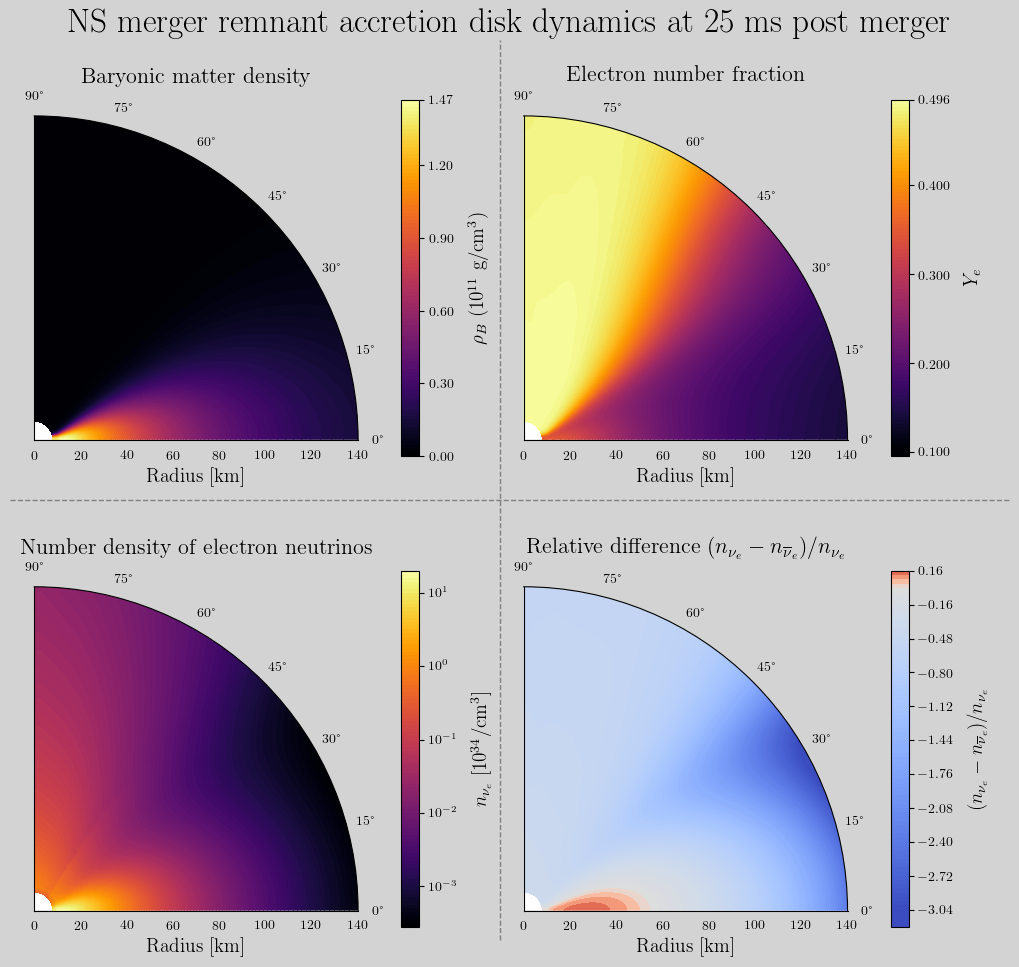

In [166]:
fig, ax = plt.subplots(figsize = (10,10))
plt.subplot(2, 2, 1, projection = 'polar')
contour = plt.contourf(yc-np.pi/2, xc/1e5, u[3]/1e11, cmap = 'inferno', levels = 100,
                      vmin = 0)
cbar = plt.colorbar(contour, shrink = 0.8, pad = 0.1, ticks = [0, 0.3, 0.6, 0.9, 1.2, 1.47])
cbar.set_label(label = r'$\rho_B$ ($10^{11}$ g/cm$^3$)', size = 14, labelpad = 10)
plt.ylim(0, 140)
plt.xlim(0, np.pi/2)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
plt.title('Baryonic matter density', fontsize = 16)
plt.grid(False)

plt.subplot(2, 2, 2, projection = 'polar')
contour = plt.contourf(yc-np.pi/2, xc/1e5, u[2]/u[0], cmap = 'inferno', levels = 100,
                      vmin = 0.1, vmax = 0.5)
cbar = plt.colorbar(contour, shrink = 0.8, pad = 0.1, ticks = [0.1, 0.2, 0.3, 0.4, 0.496])
cbar.set_label(label = r'$Y_e$', size = 14, labelpad = 10)
plt.ylim(0, 140)
plt.xlim(0, np.pi/2)
plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
plt.title('Electron number fraction', fontsize = 16)
plt.grid(False)

plt.subplot(2, 2, 3, projection = 'polar')
contour = plt.contourf(yc-np.pi/2, xc[:191]/1e5, np.log10(integrated_energy_nue[:191]/1e34),
                       cmap = 'inferno', levels = 100)
cbar = plt.colorbar(contour, pad = 0.1, ticks = [-7, -6, -5, -4, -3, -2, -1, 0, 1],
                   shrink = 0.8)
cbar.ax.set_yticklabels([r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$',
                        r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$',
                        r'$10^{1}$'])
cbar.set_label(label = r'$n_{\nu_e}$ [$10^{34}$/cm$^3$]', size = 14, labelpad = 10)
plt.ylim(0, 140)
plt.xlim(0, np.pi/2)
plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
plt.title('Number density of electron neutrinos', fontsize = 16)
plt.grid(False)

plt.subplot(2, 2, 4, projection = 'polar')
divnorm = mpl.colors.TwoSlopeNorm(vmin=-3.04, vcenter=0., vmax=0.2)
contour = plt.contourf(yc-np.pi/2, xc[:191]/1e5, (integrated_energy_nue[:191] - integrated_energy_nubare[:191])/integrated_energy_nue[:191],
                       cmap = 'coolwarm', levels = 100, norm = divnorm)
cbar = plt.colorbar(contour, pad = 0.1, ticks = [-3.04, -2.72, -2.4, -2.08, -1.76, -1.44, -1.12, -0.80,
                                                 -0.48, -0.16, 0.16],
                   shrink = 0.8, norm = divnorm)
cbar.set_label(label = r'$(n_{\nu_e} - n_{\overline{\nu}_e})/n_{\nu_e}$', size = 14, labelpad = 10)
plt.ylim(0, 140)
plt.xlim(0, np.pi/2)
plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
plt.title(r'Relative difference $(n_{\nu_e} - n_{\overline{\nu}_e})/n_{\nu_e}$', fontsize = 16)
plt.grid(False)

fig.add_artist(mpl.lines.Line2D([0, 1], [0.49, 0.49], color = 'grey', lw = 1, ls = '--'))
fig.add_artist(mpl.lines.Line2D([0.49, 0.49], [0.05, 0.95], color = 'grey', lw = 1, ls = '--'))
fig.suptitle('NS merger remnant accretion disk dynamics at 25 ms post merger', fontsize = 24)

plt.tight_layout()
fig.patch.set_color('lightgrey')
# plt.savefig(f'Plots/Black_hole_torus_dynamics_25ms_{model}_Garching_2.png', dpi = 300,
#             bbox_inches = 'tight')
plt.show()

In [73]:
# constants
cl       = 29979245800.
ergtomev = 1./1.602e-6

# compute higher moments
fabs = np.sqrt(np.sum(e[1:,...]**2,axis=0))         # flux vecter modulus
fr   = e[1,...]/fabs                          # fraction of fabs in radial direction
ft   = e[2,...]/fabs                          # fraction of fabs in theta direction
fp   = e[3,...]/fabs                          # fraction of fabs in phi direction
ff   = fabs/cl/e[0,...]                       # flux factor
ff   = np.clip(ff,0.,1.)
edd2 = 1./15.*(5.+6.*ff*2-2.*ff**3+6.*ff**4)  # Minerbo closure: 2nd mom factor
edd3 = 1./75.*ff*(                            # Minerbo closure: 3rd mom factor
    45.+10.*ff-12.*ff**2-12.*ff**3+
    38.*ff**4-12.*ff**5+18.*ff**6 )

# ... 2nd moment tensor
d1 = 0.5*(1.-edd2)
d2 = 0.5*(3.*edd2-1.)
pshape = [6]+list(fabs.shape)
P = np.zeros(pshape)
P[0,...] = (d1+d2*fr*fr)*e[0,...]  # P_rr
P[1,...] = (   d2*fr*ft)*e[0,...]  # P_rt
P[2,...] = (   d2*fr*fp)*e[0,...]  # P_rp
P[3,...] = (d1+d2*ft*ft)*e[0,...]  # P_tt
P[4,...] = (   d2*ft*fp)*e[0,...]  # P_tp
P[5,...] = (d1+d2*fp*fp)*e[0,...]  # P_pp


# ... 3rd moment tensor
d1 = 0.5*(ff-edd3)
d2 = 0.5*(5.*edd3-3.*ff)
qshape = [10]+list(fabs.shape)
Q = np.zeros(qshape)
Q[ 0,...] = (d1*fr*3.+d2*fr*fr*fr)*e[0,...]*cl  # Q_rrr
Q[ 1,...] = (d1*ft   +d2*fr*fr*ft)*e[0,...]*cl  # Q_rrt
Q[ 2,...] = (d1*fp   +d2*fr*fr*fp)*e[0,...]*cl  # Q_rrp
Q[ 3,...] = (d1*fr   +d2*fr*ft*ft)*e[0,...]*cl  # Q_rtt
Q[ 4,...] = (         d2*fr*ft*fp)*e[0,...]*cl  # Q_rtp
Q[ 5,...] = (d1*fr   +d2*fr*fp*fp)*e[0,...]*cl  # Q_rpp
Q[ 6,...] = (d1*ft*3.+d2*ft*ft*ft)*e[0,...]*cl  # Q_ttt
Q[ 7,...] = (d1*fp   +d2*ft*ft*fp)*e[0,...]*cl  # Q_ttp
Q[ 8,...] = (d1*ft   +d2*ft*fp*fp)*e[0,...]*cl  # Q_tpp
Q[ 9,...] = (d1*ft*3.+d2*fp*fp*fp)*e[0,...]*cl  # Q_ppp

In [74]:
# convert to number-based moments and integrate
en = np.copy(e) # number- and number-flux density, spectral
Pn = np.copy(P) # 2nd moment of number distribution, spectral
Qn = np.copy(Q) # 3rd moment of number distribution, spectral
for q in np.arange(nq):
    en[:,:,q,:,:] = e[:,:,q,:,:]/ec[q]*ergtomev
    Pn[:,:,q,:,:] = P[:,:,q,:,:]/ec[q]*ergtomev
    Qn[:,:,q,:,:] = Q[:,:,q,:,:]/ec[q]*ergtomev
entot = np.sum(en,axis=2) # number- and number-flux density, energy-integrated
Pntot = np.sum(Pn,axis=2) # 2nd moment of number distribution, energy-integrated
Qntot = np.sum(Qn,axis=2) # 3rd moment of number distribution, energy-integrated

### Gif

In [5]:
for time in tqdm([0,5,10,15,20,25,30,35,40,45,50]):
    f = h5py.File(root_folder+model+f'_{time}ms.h5','r+')
    # dimensions
    nu   = f['nu'][()]
    nthd = f['nthd'][()]
    nx   = f['nx'][()]
    ny   = f['ny'][()]
    nf   = f['nf'][()]
    ns   = f['ns'][()]
    nq   = f['nq'][()]

    # grids
    xl = f['xl'][()]
    xc = f['xc'][()]
    xr = f['xr'][()]
    yl = f['yl'][()]
    yc = f['yc'][()]
    yr = f['yr'][()]
    el = f['el'][()]
    ec = f['ec'][()]
    er = f['er'][()]

    # data
    u   = f['u'][()].T
    thd = f['thd'][()].T
    e   = f['e'][()].T

    f.close()
    
    fig, ax = plt.subplots(figsize = (10,10))
    plt.subplot(2, 2, 1, projection = 'polar')
    contour = plt.contourf(yc-np.pi/2, xc/1e5, u[3]/1e11, cmap = 'inferno', levels = 100,
                          vmin = 0, vmax = 2.5)
    cbar = plt.colorbar(contour, shrink = 0.8, pad = 0.1)
    cbar.set_label(label = r'$\rho_B$ ($10^{11}$ g/cm$^3$)', size = 14, labelpad = 10)
    cbar.ax.set_yticks(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels([f'{x:.2f}' for x in cbar.ax.get_yticks()])
    plt.ylim(0, 140)
    plt.xlim(0, np.pi/2)
    # plt.xticks(fontsize = 12)
    # plt.yticks(fontsize = 12)
    plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
    plt.title('Baryonic matter density', fontsize = 16)
    plt.grid(False)

    plt.subplot(2, 2, 2, projection = 'polar')
    contour = plt.contourf(yc-np.pi/2, xc/1e5, u[2]/u[0], cmap = 'inferno', levels = 100,
                          vmin = 0.1, vmax = 0.5)
    cbar = plt.colorbar(contour, shrink = 0.8, pad = 0.1)
    cbar.set_label(label = r'$Y_e$', size = 14, labelpad = 10)
    cbar.ax.set_yticks(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels([f'{x:.2f}' for x in cbar.ax.get_yticks()])
    plt.ylim(0, 140)
    plt.xlim(0, np.pi/2)
    plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
    plt.title('Electron number fraction', fontsize = 16)
    plt.grid(False)

    plt.subplot(2, 2, 3, projection = 'polar')
    contour = plt.contourf(yc-np.pi/2, xc[:191]/1e5, np.log(np.sum(e[0][0], axis = 0)[:191]/1e30),
                           cmap = 'inferno', levels = 100, vmin = -7, vmax = 0)
    cbar = plt.colorbar(contour, pad = 0.1, ticks = [-7, -6, -5, -4, -3, -2, -1, 0, 1],
                       shrink = 0.8)
    cbar.ax.set_yticklabels([r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$',
                            r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$'])
    cbar.set_label(label = r'$E_{\nu_e}$ [$10^{30}$ erg/cm$^3$]', size = 14, labelpad = 10)
    plt.ylim(0, 140)
    plt.xlim(0, np.pi/2)
    plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
    plt.title('Energy density of electron neutrinos', fontsize = 16)
    plt.grid(False)

    plt.subplot(2, 2, 4, projection = 'polar')
    divnorm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=0.3)
    contour = plt.contourf(yc-np.pi/2, xc[:191]/1e5, (np.sum(e[0][0], axis = 0)[:191] - np.sum(e[0][1], axis = 0)[:191])/np.sum(e[0][0], axis = 0)[:191],
                           cmap = 'coolwarm', levels = 100, vmax = 0.3, vmin = -0.8, norm = divnorm)
    cbar = plt.colorbar(contour, pad = 0.1, norm = divnorm,
                       shrink = 0.8)
    cbar.set_label(label = r'$(E_{\nu_e} - E_{\overline{\nu}_e})/E_{\nu_e}$', size = 14, labelpad = 10)
    cbar.ax.set_yticks(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels([f'{x:.2f}' for x in cbar.ax.get_yticks()])
    plt.ylim(0, 140)
    plt.xlim(0, np.pi/2)
    plt.xlabel('Radius [km]', fontsize = 14, labelpad = 15)
    plt.title(r'Relative difference $(E_{\nu_e} - E_{\overline{\nu}_e})/E_{\nu_e}$', fontsize = 16)
    plt.grid(False)

    fig.add_artist(mpl.lines.Line2D([0, 1], [0.49, 0.49], color = 'grey', lw = 1, ls = '--'))
    fig.add_artist(mpl.lines.Line2D([0.49, 0.49], [0.05, 0.95], color = 'grey', lw = 1, ls = '--'))
    fig.suptitle(f'NS merger remnant accretion disk at {time} ms post merger', fontsize = 24)

    plt.tight_layout()
    fig.patch.set_color('lightgrey')
    plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Black-hole-neutrinos/Gif/Black_hole_torus_dynamics_{time}ms_{model}_Garching_quarter.png', dpi = 300,
                bbox_inches = 'tight')
    plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Black-hole-neutrinos/Gif/Black_hole_torus_dynamics_{time}ms_{model}_Garching_quarter.svg', dpi = 300,
                bbox_inches = 'tight')
    plt.close()

100%|██████████| 11/11 [04:02<00:00, 22.09s/it]


## Model DD2_14529

In [7]:
files = os.listdir('/home/pedroc/Documentos/pedro/Mestradives/NS_merger_Simulation_Data_Garching/trajectories_dd2_145291_postprocT')

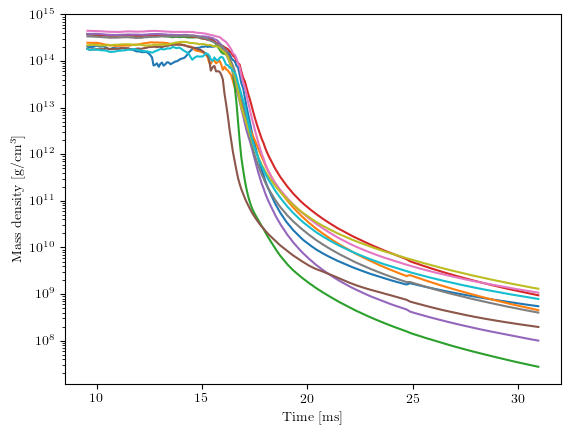

In [14]:
fig, ax = plt.subplots()
for i in range(10):
    if 'trajectory.dat' in files[i]:
        df = pd.read_csv(f'/home/pedroc/Documentos/pedro/Mestradives/NS_merger_Simulation_Data_Garching/trajectories_dd2_145291_postprocT/{files[i]}',
                   sep = '  ')
    plt.plot(df[df.columns[0]], df[df.columns[1]])
    
plt.yscale('log')
plt.xlabel('Time [ms]')
plt.ylabel(r'Mass density [g/cm$^3$]')
plt.show()

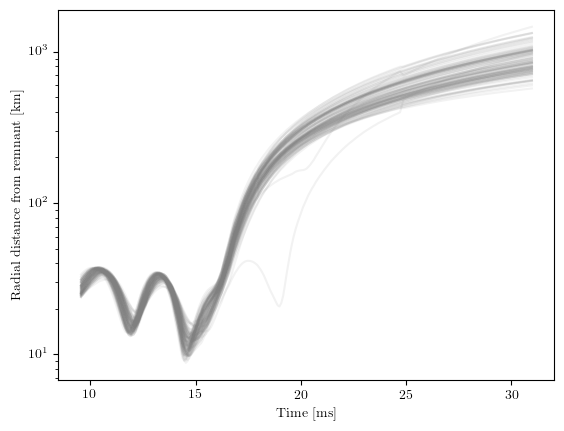

In [19]:
fig, ax = plt.subplots()
for i in range(100):
    if 'trajectory.dat' in files[i]:
        df = pd.read_csv(f'/home/pedroc/Documentos/pedro/Mestradives/NS_merger_Simulation_Data_Garching/trajectories_dd2_145291_postprocT/{files[i]}',
                   sep = '  ')
    plt.plot(df[df.columns[0]], df[df.columns[3]], color = 'grey', alpha = 0.1)
    
plt.yscale('log')
plt.xlabel('Time [ms]')
plt.ylabel(r'Radial distance from remnant [km]')
plt.show()

In [449]:
df2.columns

Index(['7436', '0.1858E-04', '0.7602E-01', '0.3097E+02', '0.5326E+15',
       '0.4786E+02', '0.0000E+00'],
      dtype='object')

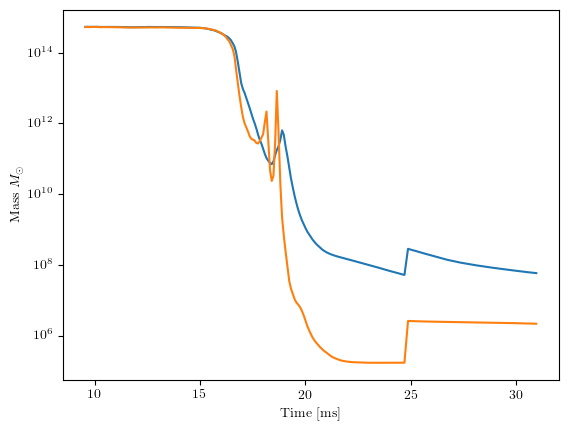

In [450]:
plt.plot(df['3796'], df['0.1935E-04'])
plt.plot(df2['7436'], df2['0.1858E-04'])
plt.yscale('log')
plt.xlabel('Time [ms]')
plt.ylabel(r'Mass $M_{\odot}$')
plt.show()